<center>
<h4>Diplomatura Datos 2021 - FaMAF - UNC</h4>
<h1>Aplicando Machine Learning para predicción de demanda</h1>
</center>
</left>
<h4>Dario Yvanoff</h4>
</left>

[Proyecto para Mentoría](https://sites.google.com/view/mentorias2021-diplodatos/aplicando-machine-learning-para-predicci%C3%B3n-de-demanda?authuser=0)

# Información Importante

En la presente notebook, se presentará la consigna a seguir para el tercer práctico correspondiente a las materias Introducción al Aprendizaje Automático y Aprendizaje Automático Supervisado. En esta notebook se enumeran las consignas que permitirán implementar los pasos necesarios en la aplicación de diferentes métodos de aprendizaje supervisado incluyendo métodos de ensemble learning. Se realizarán experimentos reproducibles para luego proceder a la evaluación de los métodos mas convenientes y la selección de hiperparámetros a partir del cálculo de las métricas pertinentes.

El objetivo final de la mentoría es poder predecir el próximo mes de venta de productos en localidades donde opera la compañía de retail proveedora de los datasets. Concretamente vamos a intentar predecir el proximo mes para una localidad dada. Sin embargo, los prácticos que se realizarán en esta mentoría son aplicables a compañías de cualquier vertical de negocio que quiera predecir la demanda.

Cada grupo debe armar un repositorio git o agregar al repositorio existente con las actividades de esta notebook. En dicho repositorio deben presentar:
- una notebook respondiendo las consignas de este práctico
- un informe (formato html, ppt o pdf) con las respuestas de este práctico. Dicho informe servirá de base para obtener la información a presentar en los videos intermedio y final de la mentoria. 

Se recomienda que el informe tenga las siguientes secciones:
- Introducción 
- Respuestas a los puntos del práctico
- Principales conclusiones




# Entregable 
Fecha de Entrega de este practico y el informe: 12/9/2021

# Introducción

Para cumplir con el objetivo de la mentoria necesitamos entender que nuestro dataset es una series de tiempo. Una serie de tiempo es una secuencia de observaciones tomadas secuencialmente en el tiempo. 
El pronóstico de series de tiempo implica tomar modelos, ajustarlos a datos históricos y luego usarlos para predecir observaciones futuras
Sin embargo, se puede transformar un problema de serie de tiempo en uno de ML Supervisado agregando lags o valores anteriores a un valor a predecir como una feature nueva. 
Este enriquecimiento del dataset se hizo en prácticos anteriores y se va a perfeccionar en este práctico. 

Otro tema a tener en cuenta es como realizar validación cruzada cuando trabajamos con series de tiempo. Cuando se trabaja con series de tiempo no es posible utilizar K-Fold Cross Validation dado que esta forma de validación cruzada no respeta el orden de las observaciones. Los problemas de series temporales requieren una validación basada en el tiempo en lugar de la validación kfold utilizada generalmente en los problemas de regresión. Kfold divide los datos de forma aleatoria y no tiene sentido comprobar la precisión del modelo mediante la predicción del período de tiempo pasado mediante el uso de datos de futuro. Por este motivo, las alternativas para la validación cruzada en datos de series de tiempo pueden ser Sliding Windows o Foward chaining cross validation. Ver https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html para mas información de Time Series cross-validation.




# Importacion de librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_percentage_error,r2_score

pd.options.display.max_columns = 50


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import Imputer

### 1- Correr el script de exploración y curación


In [1]:
file_name="./congelados_cba.csv"
df_raw = pd.read_csv(file_name)
df_raw.head()

NameError: name 'pd' is not defined

In [4]:
df_raw.drop(columns='Unnamed: 0', inplace=True)
df_raw.head()

cantidad_pedida    MA_2     t-1    totalkg  aniomes_2018-02  \
0            767.0   814.5   862.0  2381074.8                1   
1            880.0   925.5   971.0  2937792.0                1   
2           1263.0  1393.5  1524.0  4620306.6                1   
3            743.0   788.5   834.0  2254410.6                1   
4            436.0   461.5   487.0  1071252.0                1   

   aniomes_2018-03  aniomes_2018-04  aniomes_2018-05  aniomes_2018-06  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   aniomes_2018-07  aniomes_2018-08  aniomes_2018-09  aniomes_2018-10  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   aniomes_2018-11  aniomes_2018-12  aniomes_2019-01  aniomes_2019-02  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   aniomes_2019-03  aniomes_2019-04  aniomes_2019-05  aniomes_2019-06  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   aniomes_2019-07  aniomes_2019-08  aniomes_2019-09  aniomes_2019-10  ...  \
0                0                0                0                0  ...   
1                0                0                0                0  ...   
2                0                0                0                0  ...   
3                0                0                0                0  ...   
4                0                0                0                0  ...   

   sku_334  sku_345  sku_346  sku_783  sku_887  sku_888  sku_889  sku_890  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   sku_910  sku_1021  sku_1687  sku_1688  sku_1689  sku_1690  sku_1691  \
0        0         0         0         1         0         0         0   
1        0         0         0         0         0         0         0   
2        0         0         0         0         1         0         0   
3        0         0         0         0         0         1         0   
4        0         0         0         0         0         0         1   

   sku_1692  sku_1693  sku_1694  sku_1695  sku_1696  sku_1697  sku_1698  \
0         0         0         0         0         0         0         0   
1         0         1         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   sku_1705  sku_1713 

In [5]:
# Extraemos la columna de cantidad_pedida porque la necesitamos para el análisis
df_scp=df_raw.drop('cantidad_pedida',axis=1)
df_scp.head()

MA_2     t-1    totalkg  aniomes_2018-02  aniomes_2018-03  \
0   814.5   862.0  2381074.8                1                0   
1   925.5   971.0  2937792.0                1                0   
2  1393.5  1524.0  4620306.6                1                0   
3   788.5   834.0  2254410.6                1                0   
4   461.5   487.0  1071252.0                1                0   

   aniomes_2018-04  aniomes_2018-05  aniomes_2018-06  aniomes_2018-07  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   aniomes_2018-08  aniomes_2018-09  aniomes_2018-10  aniomes_2018-11  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   aniomes_2018-12  aniomes_2019-01  aniomes_2019-02  aniomes_2019-03  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   aniomes_2019-04  aniomes_2019-05  aniomes_2019-06  aniomes_2019-07  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   aniomes_2019-08  aniomes_2019-09  aniomes_2019-10  aniomes_2019-11  ...  \
0                0                0                0                0  ...   
1                0                0                0                0  ...   
2                0                0                0                0  ...   
3                0                0                0                0  ...   
4                0                0                0                0  ...   

   sku_334  sku_345  sku_346  sku_783  sku_887  sku_888  sku_889  sku_890  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   sku_910  sku_1021  sku_1687  sku_1688  sku_1689  sku_1690  sku_1691  \
0        0         0         0         1         0         0         0   
1        0         0         0         0         0         0         0   
2        0         0         0         0         1         0         0   
3        0         0         0         0         0         1         0   
4        0         0         0         0         0         0         1   

   sku_1692  sku_1693  sku_1694  sku_1695  sku_1696  sku_1697  sku_1698  \
0         0         0         0         0         0         0         0   
1         0         1         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   sku_1705  sku_1713  s

### 2. Multicolinealidad Exacta

La multicolinealidad es la relación de dependencia lineal fuerte entre más de dos variables explicativas en una regresión múltiple que incumple el supuesto de Gauss-Markov cuando es exacta. En otras palabras, la multicolinealidad es la correlación alta entre más de dos variables explicativas lo cual deriva en la imposibilidad de estimar los parámetros cuando la misma es exacta o en estimaciones muy imprecisas cuando la misma es aproximada.

En el caso de encontrar multicolinealidad, responder: ¿Cómo se puede solucionar? ¿Qué decisión tomarían al respecto?. Adicionalmente eliminar las columnas pertinentes.

A continuación puede explorar un ejemplo de como remover multicolinealidad 

https://www.kaggle.com/remilpm/how-to-remove-multicollinearity


In [6]:
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
#         if impute:
#             self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [7]:
Mult_Coll = ReduceVIF()
Data3 = Mult_Coll.fit_transform(df_scp)
Data3.head()

ReduceVIF fit
ReduceVIF transform


C:\depecho\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping aniomes_2018-02 with vif=inf
Dropping MA_2 with vif=1255.9889284849673


t-1    totalkg  aniomes_2018-03  aniomes_2018-04  aniomes_2018-05  \
0   862.0  2381074.8                0                0                0   
1   971.0  2937792.0                0                0                0   
2  1524.0  4620306.6                0                0                0   
3   834.0  2254410.6                0                0                0   
4   487.0  1071252.0                0                0                0   

   aniomes_2018-06  aniomes_2018-07  aniomes_2018-08  aniomes_2018-09  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   aniomes_2018-10  aniomes_2018-11  aniomes_2018-12  aniomes_2019-01  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   aniomes_2019-02  aniomes_2019-03  aniomes_2019-04  aniomes_2019-05  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   aniomes_2019-06  aniomes_2019-07  aniomes_2019-08  aniomes_2019-09  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   aniomes_2019-10  aniomes_2019-11  aniomes_2019-12  sku_223  ...  sku_334  \
0                0                0                0        0  ...        0   
1                0                0                0        0  ...        0   
2                0                0                0        0  ...        0   
3                0                0                0        0  ...        0   
4                0                0                0        0  ...        0   

   sku_345  sku_346  sku_783  sku_887  sku_888  sku_889  sku_890  sku_910  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   sku_1021  sku_1687  sku_1688  sku_1689  sku_1690  sku_1691  sku_1692  \
0         0         0         1         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         1         0         0         0   
3         0         0         0         0         1         0         0   
4         0         0         0         0         0         1         0   

   sku_1693  sku_1694  sku_1695  sku_1696  sku_1697  sku_1698  sku_1705  \
0         0         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0    

<AxesSubplot:>

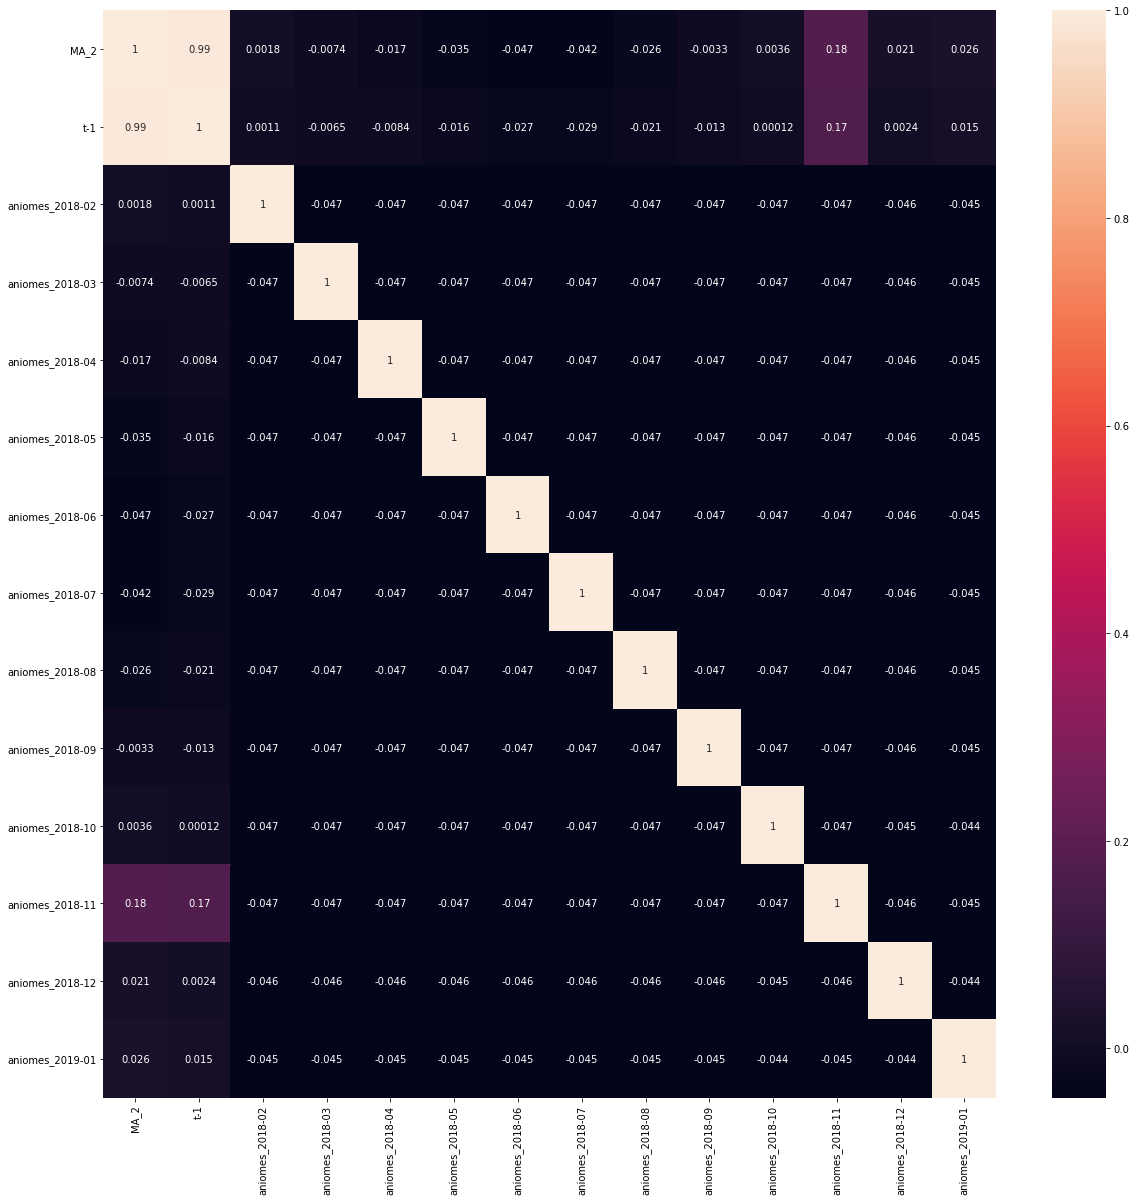

In [8]:
variables_interes=df_scp[['MA_2', 't-1', 'aniomes_2018-02', 'aniomes_2018-03',
       'aniomes_2018-04', 'aniomes_2018-05', 'aniomes_2018-06',
       'aniomes_2018-07', 'aniomes_2018-08', 'aniomes_2018-09',
       'aniomes_2018-10', 'aniomes_2018-11', 'aniomes_2018-12',
       'aniomes_2019-01']]
corr=variables_interes.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot = True)

In [9]:
corr

MA_2       t-1  aniomes_2018-02  aniomes_2018-03  \
MA_2             1.000000  0.992468         0.001809        -0.007353   
t-1              0.992468  1.000000         0.001116        -0.006511   
aniomes_2018-02  0.001809  0.001116         1.000000        -0.047482   
aniomes_2018-03 -0.007353 -0.006511        -0.047482         1.000000   
aniomes_2018-04 -0.016826 -0.008375        -0.047482        -0.047482   
aniomes_2018-05 -0.034890 -0.016324        -0.047482        -0.047482   
aniomes_2018-06 -0.047252 -0.027088        -0.047482        -0.047482   
aniomes_2018-07 -0.041827 -0.029130        -0.047482        -0.047482   
aniomes_2018-08 -0.026174 -0.021468        -0.047482        -0.047482   
aniomes_2018-09 -0.003320 -0.012915        -0.047482        -0.047482   
aniomes_2018-10  0.003561  0.000120        -0.046723        -0.046723   
aniomes_2018-11  0.177788  0.172995        -0.047482        -0.047482   
aniomes_2018-12  0.021186  0.002410        -0.045955        -0.045955   
aniomes_2019-01  0.026392  0.014588        -0.045175        -0.045175   

                 aniomes_2018-04  aniomes_2018-05  aniomes_2018-06  \
MA_2                   -0.016826        -0.034890        -0.047252   
t-1                    -0.008375        -0.016324        -0.027088   
aniomes_2018-02        -0.047482        -0.047482        -0.047482   
aniomes_2018-03        -0.047482        -0.047482        -0.047482   
aniomes_2018-04         1.000000        -0.047482        -0.047482   
aniomes_2018-05        -0.047482         1.000000        -0.047482   
aniomes_2018-06        -0.047482        -0.047482         1.000000   
aniomes_2018-07        -0.047482        -0.047482        -0.047482   
aniomes_2018-08        -0.047482        -0.047482        -0.047482   
aniomes_2018-09        -0.047482        -0.047482        -0.047482   
aniomes_2018-10        -0.046723        -0.046723        -0.046723   
aniomes_2018-11        -0.047482        -0.047482        -0.047482   
aniomes_2018-12        -0.045955        -0.045955        -0.045955   
aniomes_2019-01        -0.045175        -0.045175        -0.045175   

                 aniomes_2018-07  aniomes_2018-08  aniomes_2018-09  \
MA_2                   -0.041827        -0.026174        -0.003320   
t-1                    -0.029130        -0.021468        -0.012915   
aniomes_2018-02        -0.047482        -0.047482        -0.047482   
aniomes_2018-03        -0.047482        -0.047482        -0.047482   
aniomes_2018-04        -0.047482        -0.047482        -0.047482   
aniomes_2018-05        -0.047482        -0.047482        -0.047482   
aniomes_2018-06        -0.047482        -0.047482        -0.047482   
aniomes_2018-07         1.000000        -0.047482        -0.047482   
aniomes_2018-08        -0.047482         1.000000        -0.047482   
aniomes_2018-09        -0.047482        -0.047482         1.000000   
aniomes_2018-10        -0.046723        -0.046723        -0.046723   
aniomes_2018-11        -0.047482        -0.047482        -0.047482   
aniomes_2018-12        -0.045955        -0.045955        -0.045955   
aniomes_2019-01        -0.045175        -0.045175        -0.045175   

                 aniomes_2018-10  aniomes_2018-11  aniomes_2018-12  \
MA_2                    0.003561         0.177788         0.021186   
t-1                     0.000120         0.172995         0.002410   
aniomes_2018-02        -0.046723        -0.047482        -0.045955   
aniomes_2018-03        -0.046723        -0.047482        -0.045955   
aniomes_2018-04        -0.046723        -0.047482        -0.045955   
aniomes_2018-05        -0.046723        -0.047482        -0.045955   
aniomes_2018-06        -0.046723        -0.047482        -0.045955   
aniomes_2018-07        -0.046723        -0.047482        -0.045955   
aniomes_2018-08        -0.046723        -0.047482        -0.045955   
aniomes_2018-09        -0.046723        -0.047482        -0.045955   
aniomes_2018-10         1.000000        -0.046723    

<AxesSubplot:>

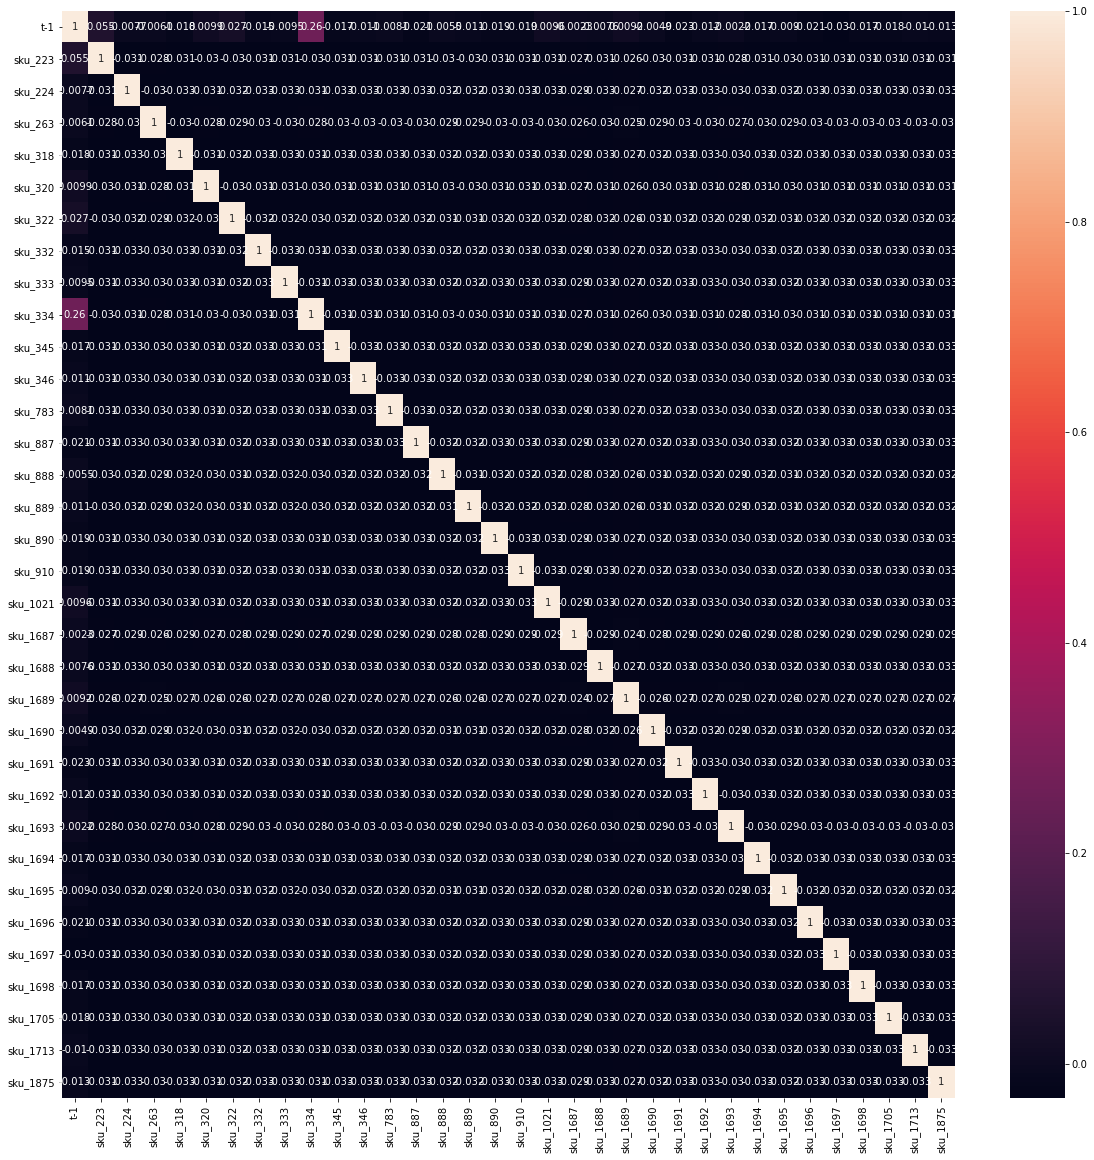

In [10]:
variables_interes2=df_scp[['t-1','sku_223',
       'sku_224', 'sku_263', 'sku_318', 'sku_320', 'sku_322', 'sku_332',
       'sku_333', 'sku_334', 'sku_345', 'sku_346', 'sku_783', 'sku_887',
       'sku_888', 'sku_889', 'sku_890', 'sku_910', 'sku_1021', 'sku_1687',
       'sku_1688', 'sku_1689', 'sku_1690', 'sku_1691', 'sku_1692', 'sku_1693',
       'sku_1694', 'sku_1695', 'sku_1696', 'sku_1697', 'sku_1698', 'sku_1705',
       'sku_1713', 'sku_1875']]
corr2=variables_interes2.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr2, annot = True)

In [11]:
#corr2

In [12]:
df_raw.drop(columns=['totalkg','aniomes_2018-02','MA_2'], inplace=True)

### 3. Comprobacion Time Serie Stationary and Trend


In [13]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [14]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='ct',nlags='auto')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [15]:
adf_test(df_raw['cantidad_pedida'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.997933
p-value                          0.001421
#Lags Used                      11.000000
Number of Observations Used    716.000000
Critical Value (1%)             -3.439516
Critical Value (5%)             -2.865585
Critical Value (10%)            -2.568924
dtype: float64


In [16]:
kpss_test(df_raw['cantidad_pedida'])

Results of KPSS Test:
Test Statistic            0.268028
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


C:\depecho\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### CONCLUSIÓN
Case 4:kpss no estacionaria y ADF estacionaria -> la serie tiene diferencia estacionaria.

In [17]:
df_raw['dif']=df_raw['t-1']-df_raw['cantidad_pedida']

In [18]:
df_raw

cantidad_pedida     t-1  aniomes_2018-03  aniomes_2018-04  \
0              767.0   862.0                0                0   
1              880.0   971.0                0                0   
2             1263.0  1524.0                0                0   
3              743.0   834.0                0                0   
4              436.0   487.0                0                0   
..               ...     ...              ...              ...   
723           1126.0   862.0                0                0   
724           1322.0  1014.0                0                0   
725           1024.0   778.0                0                0   
726           1192.0   716.0                0                0   
727           1276.0   944.0                0                0   

     aniomes_2018-05  aniomes_2018-06  aniomes_2018-07  aniomes_2018-08  \
0                  0                0                0                0   
1                  0                0                0                0   
2                  0                0                0                0   
3                  0                0                0                0   
4                  0                0                0                0   
..               ...              ...              ...              ...   
723                0                0                0                0   
724                0                0                0                0   
725                0                0                0                0   
726                0                0                0                0   
727                0                0                0                0   

     aniomes_2018-09  aniomes_2018-10  aniomes_2018-11  aniomes_2018-12  \
0                  0                0                0                0   
1                  0                0                0                0   
2                  0                0                0                0   
3                  0                0                0                0   
4                  0                0                0                0   
..               ...              ...              ...              ...   
723                0                0                0                0   
724                0                0                0                0   
725                0                0                0                0   
726                0                0                0                0   
727                0                0                0                0   

     aniomes_2019-01  aniomes_2019-02  aniomes_2019-03  aniomes_2019-04  \
0                  0                0                0                0   
1                  0                0                0                0   
2                  0                0                0                0   
3                  0                0                0                0   
4                  0                0                0                0   
..               ...              ...              ...              ...   
723                0                0                0                0   
724                0                0                0                0   
725                0                0                0                0   
726                0                0                0                0   
727                0                0                0                0   

     aniomes_2019-05  aniomes_2019-06  aniomes_2019-07  aniomes_2019-08  \
0                  0                0                0                0   
1                  0                0                0                0   
2                  0                0                0                0   
3                  0                0                0                0   
4                  0                0                0                0   
..               ...              ...              ...     

In [19]:
df_raw.shape

(728, 58)

### 4. Normalización y Estandarización de Atributos

Algunos algoritmos de aprendizaje automático lograrán un mejor rendimiento si sus datos de series de tiempo tienen una escala o distribución consistente.

Aplicar a los datasets la normalización y estandarizacion de atributos que consideren adecuada en el caso que aplique o sea necesario. 

Ejemplo https://machinelearningmastery.com/normalize-standardize-time-series-data-python/


In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_values = df_raw
mm_scaled_numeric_values = scaler.fit_transform(numeric_values)
#inversed = scaler.inverse_transform(scaled_numeric_values)
for i in range(1):
    print(mm_scaled_numeric_values[i])

[0.20706575 0.00712552 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01092442]


In [21]:
colnames=['cantidad_pedida', 't-1', 'aniomes_2018-03', 'aniomes_2018-04','aniomes_2018-05', 
        'aniomes_2018-06', 'aniomes_2018-07','aniomes_2018-08','aniomes_2018-09', 'aniomes_2018-10',
        'aniomes_2018-11', 'aniomes_2018-12','aniomes_2019-01','aniomes_2019-02', 'aniomes_2019-03', 
        'aniomes_2019-04','aniomes_2019-05', 'aniomes_2019-06', 'aniomes_2019-07','aniomes_2019-08',
        'aniomes_2019-09', 'aniomes_2019-10','aniomes_2019-11', 'aniomes_2019-12', 'sku_223','sku_224', 
        'sku_263','sku_318', 'sku_320', 'sku_322', 'sku_332', 'sku_333', 'sku_334','sku_345', 
        'sku_346', 'sku_783', 'sku_887', 'sku_888', 'sku_889','sku_890', 'sku_910', 'sku_1021', 
        'sku_1687','sku_1688', 'sku_1689','sku_1690', 'sku_1691', 'sku_1692', 'sku_1693', 'sku_1694', 
        'sku_1695','sku_1696', 'sku_1697', 'sku_1698', 'sku_1705', 'sku_1713', 'sku_1875', 'dif']

minmax_df = pd.DataFrame(mm_scaled_numeric_values,columns=colnames)
minmax_df.head()

cantidad_pedida       t-1  aniomes_2018-03  aniomes_2018-04  \
0         0.207066  0.007126              0.0              0.0   
1         0.244030  0.008192              0.0              0.0   
2         0.369316  0.013605              0.0              0.0   
3         0.199215  0.006851              0.0              0.0   
4         0.098790  0.003455              0.0              0.0   

   aniomes_2018-05  aniomes_2018-06  aniomes_2018-07  aniomes_2018-08  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   aniomes_2018-09  aniomes_2018-10  aniomes_2018-11  aniomes_2018-12  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   aniomes_2019-01  aniomes_2019-02  aniomes_2019-03  aniomes_2019-04  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   aniomes_2019-05  aniomes_2019-06  aniomes_2019-07  aniomes_2019-08  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   aniomes_2019-09  aniomes_2019-10  aniomes_2019-11  aniomes_2019-12  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              0.0              0.0   

   sku_223  ...  sku_345  sku_346  sku_783  sku_887  sku_888  sku_889  \
0      0.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0  ...      0.0      0.0      0.0      0.0      0.0      0.0   

   sku_890  sku_910  sku_1021  sku_1687  sku_1688  sku_1689  sku_1690  \
0      0.0      0.0       0.0       0.0       1.0       0.0       0.0   
1      0.0      0.0       0.0       0.0       0.0       0.0       0.0   
2      0.0      0.0       0.0       0.0       0.0       1.0       0.0   
3      0.0      0.0       0.0       0.0       0.0       0.0       1.0   
4      0.0      0.0       0.0       0.0       0.0       0.0       0.0   

   sku_1691  sku_1692  sku_1693  sku_1694  sku_1695  sku_1696  sku_1697  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       1.0       0.0       0.0       0.0       0.0       0.0       0.0   

   sku_1698  sku_1705  sku_1713  sku_1875       dif  
0       0.0       0.0       

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_values = df_raw
scaled_numeric_values = scaler.fit_transform(numeric_values)
#inversed2 = scaler.inverse_transform(scaled_numeric_values)
for i in range(2):
    print(scaled_numeric_values[i])

stscaled_df = pd.DataFrame(scaled_numeric_values, columns= colnames)
stscaled_df.head()


[-0.15389379 -0.02829665 -0.21790368 -0.21790368 -0.21790368 -0.21790368
 -0.21790368 -0.21790368 -0.21790368 -0.21442251 -0.21790368 -0.21089411
 -0.20731605 -0.20368564 -0.21790368 -0.21790368 -0.21790368 -0.21790368
 -0.21790368 -0.21790368 -0.21442251 -0.20731605 -0.19625597 -0.17652613
 -0.1723455  -0.18062146 -0.16370189 -0.18062146 -0.1723455  -0.17652613
 -0.18062146 -0.18062146 -0.1723455  -0.18062146 -0.18062146 -0.18062146
 -0.18062146 -0.17652613 -0.17652613 -0.18062146 -0.18062146 -0.18062146
 -0.15922347  5.53644055 -0.14990634 -0.17652613 -0.18062146 -0.18062146
 -0.16370189 -0.18062146 -0.17652613 -0.18062146 -0.18062146 -0.18062146
 -0.18062146 -0.18062146 -0.18062146 -0.00846277]
[ 7.54774968e-02  4.59875393e-04 -2.17903681e-01 -2.17903681e-01
 -2.17903681e-01 -2.17903681e-01 -2.17903681e-01 -2.17903681e-01
 -2.17903681e-01 -2.14422507e-01 -2.17903681e-01 -2.10894114e-01
 -2.07316045e-01 -2.03685640e-01 -2.17903681e-01 -2.17903681e-01
 -2.17903681e-01 -2.17903681e-01 

cantidad_pedida       t-1  aniomes_2018-03  aniomes_2018-04  \
0        -0.153894 -0.028297        -0.217904        -0.217904   
1         0.075477  0.000460        -0.217904        -0.217904   
2         0.852904  0.146353        -0.217904        -0.217904   
3        -0.202610 -0.035684        -0.217904        -0.217904   
4        -0.825769 -0.127230        -0.217904        -0.217904   

   aniomes_2018-05  aniomes_2018-06  aniomes_2018-07  aniomes_2018-08  \
0        -0.217904        -0.217904        -0.217904        -0.217904   
1        -0.217904        -0.217904        -0.217904        -0.217904   
2        -0.217904        -0.217904        -0.217904        -0.217904   
3        -0.217904        -0.217904        -0.217904        -0.217904   
4        -0.217904        -0.217904        -0.217904        -0.217904   

   aniomes_2018-09  aniomes_2018-10  aniomes_2018-11  aniomes_2018-12  \
0        -0.217904        -0.214423        -0.217904        -0.210894   
1        -0.217904        -0.214423        -0.217904        -0.210894   
2        -0.217904        -0.214423        -0.217904        -0.210894   
3        -0.217904        -0.214423        -0.217904        -0.210894   
4        -0.217904        -0.214423        -0.217904        -0.210894   

   aniomes_2019-01  aniomes_2019-02  aniomes_2019-03  aniomes_2019-04  \
0        -0.207316        -0.203686        -0.217904        -0.217904   
1        -0.207316        -0.203686        -0.217904        -0.217904   
2        -0.207316        -0.203686        -0.217904        -0.217904   
3        -0.207316        -0.203686        -0.217904        -0.217904   
4        -0.207316        -0.203686        -0.217904        -0.217904   

   aniomes_2019-05  aniomes_2019-06  aniomes_2019-07  aniomes_2019-08  \
0        -0.217904        -0.217904        -0.217904        -0.217904   
1        -0.217904        -0.217904        -0.217904        -0.217904   
2        -0.217904        -0.217904        -0.217904        -0.217904   
3        -0.217904        -0.217904        -0.217904        -0.217904   
4        -0.217904        -0.217904        -0.217904        -0.217904   

   aniomes_2019-09  aniomes_2019-10  aniomes_2019-11  aniomes_2019-12  \
0        -0.214423        -0.207316        -0.196256        -0.176526   
1        -0.214423        -0.207316        -0.196256        -0.176526   
2        -0.214423        -0.207316        -0.196256        -0.176526   
3        -0.214423        -0.207316        -0.196256        -0.176526   
4        -0.214423        -0.207316        -0.196256        -0.176526   

    sku_223  ...   sku_345   sku_346   sku_783   sku_887   sku_888   sku_889  \
0 -0.172345  ... -0.180621 -0.180621 -0.180621 -0.180621 -0.176526 -0.176526   
1 -0.172345  ... -0.180621 -0.180621 -0.180621 -0.180621 -0.176526 -0.176526   
2 -0.172345  ... -0.180621 -0.180621 -0.180621 -0.180621 -0.176526 -0.176526   
3 -0.172345  ... -0.180621 -0.180621 -0.180621 -0.180621 -0.176526 -0.176526   
4 -0.172345  ... -0.180621 -0.180621 -0.180621 -0.180621 -0.176526 -0.176526   

    sku_890   sku_910  sku_1021  sku_1687  sku_1688  sku_1689  sku_1690  \
0 -0.180621 -0.180621 -0.180621 -0.159223  5.536441 -0.149906 -0.176526   
1 -0.180621 -0.180621 -0.180621 -0.159223 -0.180621 -0.149906 -0.176526   
2 -0.180621 -0.180621 -0.180621 -0.159223 -0.180621  6.670832 -0.176526   
3 -0.180621 -0.180621 -0.180621 -0.159223 -0.180621 -0.149906  5.664884   
4 -0.180621 -0.180621 -0.180621 -0.159223 -0.180621 -0.149906 -0.176526   

   sku_1691  sku_1692  sku_1693  sku_1694  sku_1695  sku_1696  sku_1697  \
0 -0.180621 -0.180621 -0.163702 -0.180621 -0.176526 -0.180621 -0.180621   
1 -0.180621 -0.180621  6.108665 -0.180621 -0.176526 -0.180621 -0.180621   
2 -0.180621 -0.180621 -0.163702 -0.180621 -0.176526 -0.180621 -0.180621   
3 -0.180621 -0.180621 -0.163702 -0.180621 -0.176526 -0.180621 -0.180621   
4  5.536441 -0.180621 -0.163702 -0.180621 -0.176526 -0.180621 -0.180621   

   sku_1698  sku_1705  sku_1

### 5. División en Train/Test y Aplicando Modelos


- Linear Support Vector Regression ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR))
- Stochastic Gradient Descent ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor))
- KNeighborsRegressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor))
- Prediction Voting Regressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor))
- XGBRegressor  ([Doc](https://xgboost.readthedocs.io/en/latest/python/python_api.html)) 
- Random Forest Regressor ([Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)) 
- LGBMRegressor ([Doc](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)) 

De estos tipos de modelos, cuál creen que es el más adecuado para nuestro caso de aplicación? 

**Elegir el modelo o los modelos que consideren que mejor aplica a nuestro problema.** Para ello, recuerden que los pasos a seguir en la selección pueden esquematizarse como sigue:

#### - Selección de Regularizador

 ¿Utilizarán algún regularizador?¿Cuál?

#### - Selección de Función de Costo

¿Cuál será la función de costo utilizada?

#### - Justificación de las Selecciones

¿Por qué eligieron el modelo, el regularizador y la función de costo previas?

Finalmente, para el modelo selecionado:

- Utilizar el método *Grid Search*, o de búsqueda exahustiva, con *cross-validation* para profundizar en la búsqueda y selección de hiperparámetros.

- Calcular métricas (https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) sobre el conjunto de entrenamiento y de evaluación para los mejores parámetros obtenidos:
    + MAPE, MSE, MAE, RMSE, R Square
    + Comparar las métricas obtenidas en cada modelo y obtener conclusiones.


## Prueba de los modelos por Default

In [23]:
modelos = {'XGB': XGBRegressor(seed=42),
           'RFR': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
           'KNR': KNeighborsRegressor(n_neighbors=3),
           'LGBM': LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=-1,learning_rate=0.1,n_estimators=100,objective='regression', min_split_gain=0.0,min_child_samples=20,subsample=1.0,subsample_freq=0,colsample_bytree=1.0,reg_alpha=0.0,reg_lambda=0.0,random_state=None,silent=True),
           'LSVR': LinearSVR(epsilon=0, C=0.3, fit_intercept=True,max_iter=10000),
           'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
           'VOT': VotingRegressor([('linear', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))]),
           'SGD': SGDRegressor(max_iter=2000, tol=1e-3)
          }

##Primero voy a probar los modelos sin Escalar- EL xgboost no necesita datos escalados ni normalizados

In [24]:
train = 0.8
test = 1 - train

XGB: 0.928530 (0.051680)
RFR: 0.882623 (0.074792)
KNR: 0.928742 (0.051216)
LGBM: 0.835063 (0.135114)


C:\depecho\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LSVR: 1.000000 (0.000000)
SVR: -0.285681 (0.266638)
VOT: 0.970656 (0.018698)
SGD: -394539876526793242359889920.000000 (546288104755800479696420864.000000)


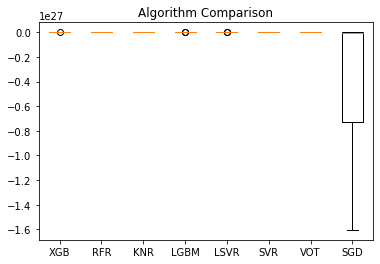

{'modelo': 'XGB', 'rmse': 73.26474773583224, 'mape': 0.039169327893468726, 'r2': 0.9793548257257474}
{'modelo': 'RFR', 'rmse': 98.15875549513068, 'mape': 0.03340117212573142, 'r2': 0.96294161207177}
{'modelo': 'KNR', 'rmse': 76.71670493334244, 'mape': 0.025214144468673375, 'r2': 0.9773635500262933}
{'modelo': 'LGBM', 'rmse': 98.731175351724, 'mape': 0.034108311424053794, 'r2': 0.9625081344988283}
{'modelo': 'LSVR', 'rmse': 0.0008482097455804033, 'mape': 5.358096267649786e-07, 'r2': 0.9999999999972329}
{'modelo': 'SVR', 'rmse': 639.8758039095779, 'mape': 0.3611639781346615, 'r2': -0.574779716943729}
{'modelo': 'VOT', 'rmse': 49.079377747565026, 'mape': 0.016700586062865518, 'r2': 0.9907354030179426}
{'modelo': 'SGD', 'rmse': 1.930659301974403e+16, 'mape': 13851639516957.477, 'r2': -1.4336387125302525e+27}


In [25]:
##MODELOS POR DEFAULT sin estandarizar datos
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

results = []
names = []
summary_list = []

split = int(df_raw.shape[0]*train)


df_raw.loc[df_raw.iloc[:split].index, 'train_test'] = 'train'
df_raw.loc[df_raw.iloc[split:].index, 'train_test'] = 'test'

x_train = df_raw[df_raw['train_test']=='train'].copy()
x_test = df_raw[df_raw['train_test']=='test'].copy()

y_train = x_train['cantidad_pedida'].copy()
y_test = x_test['cantidad_pedida'].copy()

x_train = x_train.drop(columns=['cantidad_pedida', 'train_test'])
x_test = x_test.drop(columns=['cantidad_pedida', 'train_test'])

for name, model in modelos.items():
    tscv = TimeSeriesSplit(n_splits=10)

    cv_results = cross_val_score(model, x_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

for nom_modelo, modelo in modelos.items():
    summary = dict()
    summary['modelo'] = nom_modelo
    modelo.fit(x_train, y_train)
    y_pred = modelo.predict(x_test)
    summary['rmse'] = np.sqrt(mean_squared_error(y_test, y_pred))
    summary['mape'] = mean_absolute_percentage_error(y_test, y_pred)
    summary['r2'] = r2_score(y_test,y_pred)
    print(summary)
    summary_list.append(summary)

XGB: 0.897848 (0.064584)
RFR: 0.881564 (0.076012)
KNR: 0.694239 (0.259047)
LGBM: 0.835269 (0.131719)
LSVR: 0.404353 (0.400747)
SVR: 0.086553 (0.664281)
VOT: 0.526293 (0.788997)
SGD: -0.060055 (0.223703)


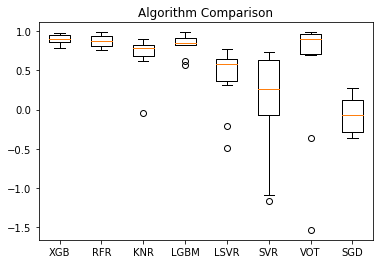

In [26]:
##MODELOS POR DEFAULT escalados minmax

results = []
names = []
summary_list = []

split = int(minmax_df.shape[0]*train)


minmax_df.loc[minmax_df.iloc[:split].index, 'train_test'] = 'train'
minmax_df.loc[minmax_df.iloc[split:].index, 'train_test'] = 'test'

x_train_mmax = minmax_df[minmax_df['train_test']=='train'].copy()
x_test_mmax = minmax_df[minmax_df['train_test']=='test'].copy()

y_train_mmax = x_train_mmax['cantidad_pedida'].copy()
y_test_mmax = x_test_mmax['cantidad_pedida'].copy()

x_train_mmax = x_train_mmax.drop(columns=['cantidad_pedida', 'train_test'])
x_test_mmax = x_test_mmax.drop(columns=['cantidad_pedida', 'train_test'])

for name, model in modelos.items():
    tscv = TimeSeriesSplit(n_splits= 10)

    cv_results = cross_val_score(model, x_train_mmax, y_train_mmax, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [27]:
for nom_modelo, modelo in modelos.items():
    summary = dict()
    summary['modelo'] = nom_modelo
    modelo.fit(x_train_mmax, y_train_mmax)
    y_pred_mmax = modelo.predict(x_test_mmax)
    summary['rmse'] = np.sqrt(mean_squared_error(y_test_mmax, y_pred_mmax))
    summary['mape'] = mean_absolute_percentage_error(y_test_mmax, y_pred_mmax)
    summary['r2'] = r2_score(y_test_mmax,y_pred_mmax)
    print(summary)
    summary_list.append(summary)

{'modelo': 'XGB', 'rmse': 0.027299565282747903, 'mape': 0.04939734212707831, 'r2': 0.9732125868265511}
{'modelo': 'RFR', 'rmse': 0.03251770720239292, 'mape': 0.03873496990679504, 'r2': 0.9619933889839718}
{'modelo': 'KNR', 'rmse': 0.08845782983168111, 'mape': 0.21117090298611116, 'r2': 0.7187504252477249}
{'modelo': 'LGBM', 'rmse': 0.030978020800817553, 'mape': 0.04062995068453398, 'r2': 0.9655073431668215}
{'modelo': 'LSVR', 'rmse': 0.1438875576986003, 'mape': 0.35002258520514046, 'r2': 0.2558409020866875}
{'modelo': 'SVR', 'rmse': 0.12128565888065533, 'mape': 0.3159199294357434, 'r2': 0.47126480833629814}
{'modelo': 'VOT', 'rmse': 0.01611789107271607, 'mape': 0.021491141166973565, 'r2': 0.9906623896688753}
{'modelo': 'SGD', 'rmse': 0.18159927158710262, 'mape': 0.39234430884615124, 'r2': -0.1853524943536098}


XGB: 0.906515 (0.064150)
RFR: 0.881547 (0.075377)
KNR: 0.596852 (0.376888)
LGBM: 0.847190 (0.117433)
LSVR: 0.521999 (0.419020)
SVR: -0.183829 (0.268378)
VOT: 0.941508 (0.034298)
SGD: 0.358605 (0.512644)


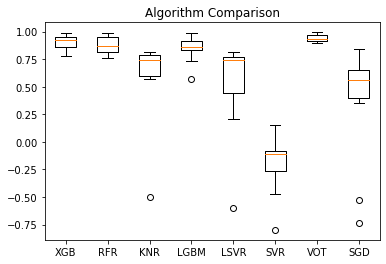

{'modelo': 'XGB', 'rmse': 0.15518407970944004, 'mape': 0.20729838727881056, 'r2': 0.9775197290159573}
{'modelo': 'RFR', 'rmse': 0.1993931511245045, 'mape': 0.18628203042180216, 'r2': 0.9628868612231354}
{'modelo': 'KNR', 'rmse': 0.7237307485306297, 'mape': 1.8972352682124638, 'r2': 0.5110535908866245}
{'modelo': 'LGBM', 'rmse': 0.1901353751114226, 'mape': 0.19374938694027027, 'r2': 0.9662531637936848}
{'modelo': 'LSVR', 'rmse': 0.5097821653538067, 'mape': 1.0882904631529966, 'r2': 0.7574079931174842}
{'modelo': 'SVR', 'rmse': 1.1179195604155994, 'mape': 1.2057141478208193, 'r2': -0.16661705776205782}
{'modelo': 'VOT', 'rmse': 0.09998880577962954, 'mape': 0.10584082163959868, 'r2': 0.9906672426430415}
{'modelo': 'SGD', 'rmse': 0.7978899616892604, 'mape': 1.8348045623539555, 'r2': 0.40571712683585526}


In [28]:
##MODELOS POR DEFAULT escalados StandardScaled

results = []
names = []
summary_list = []

split = int(stscaled_df.shape[0]*train)


stscaled_df.loc[stscaled_df.iloc[:split].index, 'train_test'] = 'train'
stscaled_df.loc[stscaled_df.iloc[split:].index, 'train_test'] = 'test'

x_train_st = stscaled_df[stscaled_df['train_test']=='train'].copy()
x_test_st = stscaled_df[stscaled_df['train_test']=='test'].copy()

y_train_st = x_train_st['cantidad_pedida'].copy()
y_test_st = x_test_st['cantidad_pedida'].copy()

x_train_st = x_train_st.drop(columns=['cantidad_pedida', 'train_test'])
x_test_st = x_test_st.drop(columns=['cantidad_pedida', 'train_test'])

for name, model in modelos.items():
    tscv = TimeSeriesSplit(n_splits=10)

    cv_results = cross_val_score(model, x_train_st, y_train_st, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

for nom_modelo, modelo in modelos.items():
    summary = dict()
    summary['modelo'] = nom_modelo
    modelo.fit(x_train_st, y_train_st)
    y_pred_st= modelo.predict(x_test_st)
    summary['rmse'] = np.sqrt(mean_squared_error(y_test_st, y_pred_st))
    summary['mape'] = mean_absolute_percentage_error(y_test_st, y_pred_st)
    summary['r2'] = r2_score(y_test_st,y_pred_st)
    print(summary)
    summary_list.append(summary)

### GridSearch RANDOM FOREST REG (df_raw)

In [30]:
from sklearn.model_selection import GridSearchCV

scoring = r2_score
scoring = 'r2'  

RF_model = RandomForestRegressor(random_state=0)
param_search = { 
   'n_estimators': [20, 50, 100],
   'max_features': ['auto', 'sqrt', 'log2'],
   'max_depth' : [i for i in range(5,15)],
   'min_samples_split' : [3, 5, 10],
   'min_samples_leaf' : [2, 3, 5, 7]
}

tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator= RF_model, cv=tscv, param_grid=param_search, scoring = scoring)
gsearch.fit(x_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [31]:
print(best_score) 
print(best_model) 

0.8860252401458573
RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=3,
                      n_estimators=50, random_state=0)


In [33]:
y_pred = best_model.predict(x_test)

In [34]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
#rmse y mape
print('mape: %.2f' % mean_absolute_percentage_error(y_test, y_pred))
print('rmse: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))  

Mean squared error: 8853.98
Variance score: 0.97
mape: 0.03
rmse: 94.10


## GRID SEARCH NUEVO RFR

In [104]:
from sklearn.model_selection import GridSearchCV

scoring = r2_score
scoring = 'r2'  

RF_model = RandomForestRegressor(random_state=0)
param_search_rfr = { 
   'n_estimators': list(np.arange(20, 100, 10)),
   'max_features': ['auto', 'sqrt', 'log2'],
   'max_depth' : [i for i in range(5,15)],
   'min_samples_split' : list(np.arange(2, 10, 1)),
   'min_samples_leaf' : list(np.arange(2, 8, 1))
}

tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator= RF_model, cv=tscv, param_grid=param_search_rfr, scoring = scoring)

gsearch.fit(x_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

print(best_score) 
print(best_model)


KeyboardInterrupt: 

In [ ]:
y_pred = best_model.predict(x_test)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
#rmse y mape
print('mape: %.2f' % mean_absolute_percentage_error(y_test, y_pred))
print('rmse: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))  

### GridSearch KNR (min_max/ y Standard scaled)

In [79]:
KNR_model =  KNeighborsRegressor()

grid_params = {
    'n_neighbors': list (np.arange(3,8,1)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'minkowski', 'manhattan']
}

KNR_gs = GridSearchCV (estimator=KNR_model,cv=tscv, param_grid=grid_params, verbose=1,n_jobs=-1)

KNR_results= KNR_gs.fit(x_train_mmax, y_train_mmax)
KNR_best_score = KNR_results.best_score_
KNR_best_model = KNR_results.best_estimator_

print(KNR_best_score) 
print(KNR_best_model)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
0.7204291636726473
KNeighborsRegressor(metric='euclidean')


In [80]:
y_pred = KNR_best_model.predict(x_test_mmax)

In [81]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test_mmax, y_pred_mmax))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test_mmax, y_pred_mmax))
#rmse y mape
print('mape: %.2f' % mean_absolute_percentage_error(y_test_mmax, y_pred_mmax))
print('rmse: %.2f' % np.sqrt(mean_squared_error(y_test_mmax, y_pred_mmax)))  

Mean squared error: 0.03
Variance score: -0.19
mape: 0.39
rmse: 0.18


In [83]:
KNR_model =  KNeighborsRegressor()

grid_params = {
    'n_neighbors': list (np.arange(3,8,1)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'minkowski', 'manhattan']
}

KNR_gs = GridSearchCV (estimator=KNR_model,cv=tscv, param_grid=grid_params, verbose=1,n_jobs=-1)

KNR_results= KNR_gs.fit(x_train_st, y_train_st)
KNR_best_score = KNR_results.best_score_
KNR_best_model = KNR_results.best_estimator_

print(KNR_best_score) 
print(KNR_best_model)

y_pred = KNR_best_model.predict(x_test_st)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
0.6456890684137886
KNeighborsRegressor(metric='euclidean')


In [84]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test_st, y_pred_st))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test_st, y_pred_st))
#rmse y mape
print('mape: %.2f' % mean_absolute_percentage_error(y_test_st, y_pred_st))
print('rmse: %.2f' % np.sqrt(mean_squared_error(y_test_st, y_pred_st)))  

Mean squared error: 0.64
Variance score: 0.41
mape: 1.83
rmse: 0.80


### Prueba SVR

In [88]:
modelo_SVR = {'SVR': SVR(),
           'SVR1': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
           'SVR2': SVR(kernel='rbf', C=100, gamma="scale", epsilon=.1), #modifico con "c" y gamma
            'SVR3': SVR(kernel='rbf', C=200, gamma="scale", epsilon=.1),
            'SVR4': SVR(kernel='rbf', C=300, gamma="scale", epsilon=.1),
           }

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
scoring = r2_score
scoring = 'r2' 

model = SVR()
param_search = {'kernel' : ('linear','poly', 'rbf', 'sigmoid'),
                'C' : [100,200,300],
                'degree' : [5],
               "epsilon": [0.0003, 0.007],
               'coef0' : [0.01,0.5],
               'gamma': [0.008, 0.001, 1, 1.3, 5]
                 }

svr_gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring=scoring)
svr_gsearch.fit(x_train_st, y_train_st)
svr_best_score = svr_gsearch.best_score_
svr_best_model = svr_gsearch.best_estimator_


In [98]:
print(svr_best_score)
print(svr_best_model)

0.5585437276051141
SVR(C=300, coef0=0.01, degree=5, epsilon=0.0003, gamma=0.001)


In [ ]:
modelos = {'VOT': VotingRegressor([('linear', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))]),
           'VOT2': VotingRegressor([('linear', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))]),
           'VOT3': VotingRegressor([('linear', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42))]),
           'VOT4': VotingRegressor([('linear', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42))]),
          }

In [ ]:
# Seleccion de Periodo - Cambiar df por el nombre de su dataset
#periodos = {'Completo': df_raw[df_raw['anio']>=2019]
#           }

### 6. Grid Search del Modelo Seleccionado

Seleccionamos el modelo XGB para realizar el grid search

In [35]:
#from sklearn.model_selection import GridSearchCV

scoring = r2_score
scoring = 'r2'  

model =  XGBRegressor(seed=42)
param_xgb_search = { 
    'max_depth': [3,5,6,7,10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500, 1000],
    'colsample_bytree': [0.3, 0.7],   
}

gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_xgb_search, scoring=scoring)
gsearch.fit(x_train, y_train)
XGB_best_score = gsearch.best_score_
XGB_best_model = gsearch.best_estimator_

In [36]:
print(XGB_best_score)
print(XGB_best_model)

0.921728279058059
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)


In [38]:
y_pred = XGB_best_model.predict(x_test)

# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
#rmse y mape
print('mape: %.2f' % mean_absolute_percentage_error(y_test, y_pred))
print('rmse: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))  

Mean squared error: 4971.93
Variance score: 0.98
mape: 0.03
rmse: 70.51


Text(0.5, 1.0, 'Importancia de features modelo XGB')

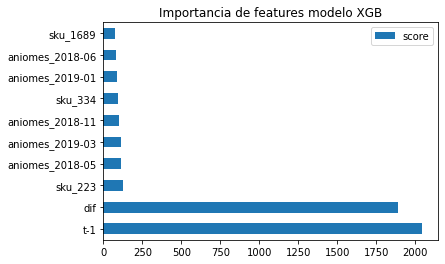

In [47]:
feature_important = XGB_best_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False).head(10)
data.plot(kind='barh')
plt.title('Importancia de features modelo XGB')

In [58]:
#from sklearn.model_selection import GridSearchCV

scoring = r2_score
#scoring = 'r2'  

model =  XGBRegressor(seed=42,use_label_encoder=False,eval_metric="logloss")
param_xgb_search = { 
    'max_depth': list(np.arange(1,10)),
    'learning_rate': list(np.arange(0.1,0.41,0.1)),
    'n_estimators': list(np.arange (100, 1100, 100)),
    'colsample_bytree': list(np.arange(0.5, 1.01, 0.1)),
}

gsearch = GridSearchCV(estimator=model,cv=tscv, param_grid=param_xgb_search, scoring= "r2")
gsearch.fit(x_train, y_train)
XGB_best_score = gsearch.best_score_
XGB_best_model = gsearch.best_estimator_

In [60]:
XGB_best_score

0.9613855940066408

In [61]:
XGB_best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9999999999999999,
             eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.30000000000000004,
             max_delta_step=0, max_depth=1, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
             use_label_encoder=False, validate_parameters=1, verbosity=None)

In [62]:
y_pred = XGB_best_model.predict(x_test)

In [63]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
#rmse y mape
print('mape: %.2f' % mean_absolute_percentage_error(y_test, y_pred))
print('rmse: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))  

Mean squared error: 3257.51
Variance score: 0.99
mape: 0.03
rmse: 57.07


Text(0.5, 1.0, 'Importancia de features modelo XGB')

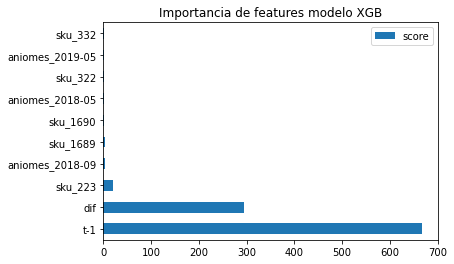

In [65]:
feature_important = XGB_best_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False).head(10)
data.plot(kind='barh')
plt.title('Importancia de features modelo XGB')

## GRID SEARCH MODELO FINAL XGB con regularizador 

In [86]:
scoring = r2_score  

model2 =  XGBRegressor(seed=42,use_label_encoder=False,eval_metric="logloss")
param_xgb_search = { 
    'max_depth': list(np.arange(1,10)),
    'learning_rate': list(np.arange(0.1,0.41,0.1)),
    'n_estimators': list(np.arange (100, 1100, 100)),
    'colsample_bytree': list(np.arange(0.5, 1.01, 0.1)),
    'reg_alpha':list(np.arange(0.5,0.9,0.1))
}

gsearch = GridSearchCV(estimator=model2,cv=tscv, param_grid=param_xgb_search, scoring= "r2")
gsearch.fit(x_train, y_train)
XGB_best_score = gsearch.best_score_
XGB_best_model = gsearch.best_estimator_

In [93]:
XGB_best_score

0.9613757657177947

In [100]:
XGB_best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9999999999999999,
             eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.30000000000000004,
             max_delta_step=0, max_depth=1, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, random_state=42, reg_alpha=0.6, reg_lambda=1,
             scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
             use_label_encoder=False, validate_parameters=1, verbosity=None)

In [94]:
y_pred = XGB_best_model.predict(x_test)

In [95]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))
#rmse y mape
print('mape: %.2f' % mean_absolute_percentage_error(y_test, y_pred))
print('rmse: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))  

Mean squared error: 3261.03
Variance score: 0.99
mape: 0.03
rmse: 57.11


Text(0.5, 1.0, 'Importancia de features modelo XGB con regularizador')

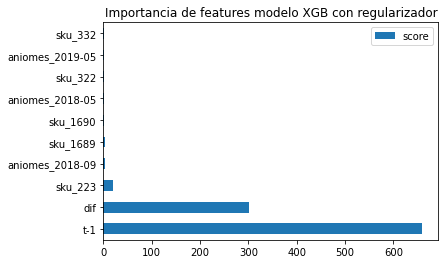

In [99]:
feature_important = XGB_best_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False).head(10)
data.plot(kind='barh')
plt.title('Importancia de features modelo XGB con regularizador')